In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Exploration

In [2]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


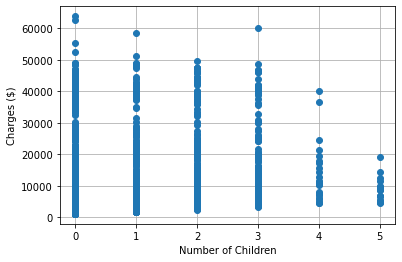

In [3]:
plt.plot('children', 'charges', 'o', data = insurance)
plt.xlabel('Number of Children')
plt.ylabel('Charges ($)')
plt.grid()
plt.show()

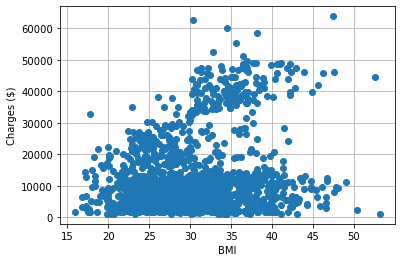

In [4]:
plt.plot('bmi', 'charges', 'o', data = insurance)
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.grid()
plt.show()

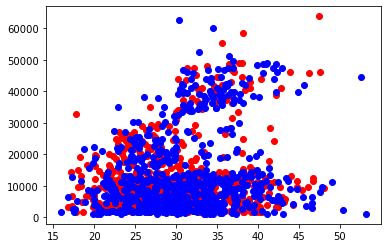

In [5]:
# insurance['sex_color'] = np.where(insurance['sex'] == 'female', 'red', 'blue')

colors = ['red', 'blue']

for i in insurance['sex'].unique():
    
    temp = insurance[insurance['sex'] == i]
    plt.scatter(temp['bmi'], temp['charges'], color = colors[i])

In [6]:
X = insurance[insurance['charges'] >= 30000]
X.describe()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,40.376543,0.635802,34.845432,1.166667,0.938272,40761.308558,0.216049,0.179012,0.376543
std,14.472512,0.482697,4.736925,1.137994,0.241408,6165.955587,0.412824,0.384551,0.486021
min,18.000000,0.000000,17.765000,0.000000,0.000000,30063.580550,0.000000,0.000000,0.000000
25%,27.000000,0.000000,31.692500,0.000000,1.000000,36203.125612,0.000000,0.000000,0.000000
50%,42.000000,1.000000,34.650000,1.000000,1.000000,39854.111650,0.000000,0.000000,0.000000
75%,52.750000,1.000000,37.027500,2.000000,1.000000,44481.999400,0.000000,0.000000,1.000000
max,64.000000,1.000000,52.580000,4.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


In [7]:
X['children'].value_counts()

0    64
2    39
1    34
3    23
4     2
Name: children, dtype: int64

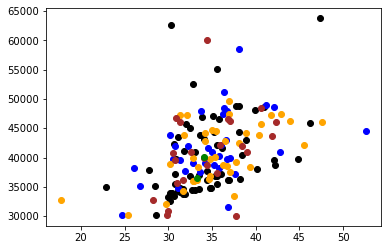

In [29]:
colors = ['black', 'blue', 'orange', 'brown', 'green']

for i in range(0, 5):
    temp = X[X['children'] == i]
    plt.scatter(temp['bmi'], temp['charges'], color = colors[i])

# plt.plot('bmi', 'charges', 'o', data = X)
# plt.xlabel('BMI')
# plt.ylabel('Charges ($)')
# plt.grid()
# plt.show()

In [24]:
Y = insurance[insurance['charges'] < 30000]
Y.describe()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,39.045918,0.487245,30.087300,1.085034,0.103741,9483.412419,0.245748,0.251701,0.257653
std,13.989404,0.500050,6.041278,1.214626,0.305055,6565.954307,0.430713,0.434175,0.437528
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,26.000000,0.000000,25.786250,0.000000,0.000000,4348.852338,0.000000,0.000000,0.000000
50%,39.000000,0.000000,29.700000,1.000000,0.000000,8246.436950,0.000000,0.000000,0.000000
75%,51.000000,1.000000,33.888750,2.000000,0.000000,12629.348375,0.000000,1.000000,1.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,29523.165600,1.000000,1.000000,1.000000


In [27]:
Y['children'].value_counts()

0    510
1    290
2    201
3    134
4     23
5     18
Name: children, dtype: int64